# Backtest Playground

`Run -> Run All Cells` だけで、データ取得・バックテスト・JSON保存・可視化まで実行します。

In [1]:
from pathlib import Path
import os
import sys

CANDIDATE_ROOTS = [
    Path.cwd(),
    Path.cwd().parent,
    Path('/Users/umegakigen/gitProjects/crypto_trade_bot'),
]

ROOT = None
for candidate in CANDIDATE_ROOTS:
    if (candidate / 'pybot').exists() and (candidate / 'research').exists():
        ROOT = candidate
        break

if ROOT is None:
    raise RuntimeError('project root not found')

os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print('ROOT =', ROOT)


ROOT = /Users/umegakigen/gitProjects/crypto_trade_bot


In [2]:
# Parameters
PAIR = 'SOL/USDC'
TIMEFRAME = '2h'  # '2h' or '4h'
YEARS_OF_DATA = 2
BARS_PER_DAY_BY_TIMEFRAME = {'2h': 12, '4h': 6}
if TIMEFRAME not in BARS_PER_DAY_BY_TIMEFRAME:
    raise ValueError(f'unsupported timeframe: {TIMEFRAME}')
LIMIT = YEARS_OF_DATA * 365 * BARS_PER_DAY_BY_TIMEFRAME[TIMEFRAME]
REFRESH_DATA = False

USE_FIRESTORE_CURRENT_CONFIG = True
LIVE_CONFIG_PATH = ROOT / 'research/config.live.current.json'
DEFAULT_CONFIG_PATH = ROOT / 'research/config.json'
CONFIG_PATH = LIVE_CONFIG_PATH if USE_FIRESTORE_CURRENT_CONFIG else DEFAULT_CONFIG_PATH

CSV_PATH = ROOT / (f'research/data/raw/solusdc_{TIMEFRAME}_live.csv' if USE_FIRESTORE_CURRENT_CONFIG else f'research/data/raw/solusdc_{TIMEFRAME}.csv')
OUTPUT_PATH = ROOT / ('research/data/processed/backtest_live_config.json' if USE_FIRESTORE_CURRENT_CONFIG else 'research/data/processed/backtest_latest.json')

INITIAL_CAPITAL_JPY = 1_000_000

print('USE_FIRESTORE_CURRENT_CONFIG =', USE_FIRESTORE_CURRENT_CONFIG)
print('LIMIT =', LIMIT, f'(about {YEARS_OF_DATA} years)')
print('CONFIG_PATH =', CONFIG_PATH)
print('CSV_PATH =', CSV_PATH)
print('OUTPUT_PATH =', OUTPUT_PATH)
print('INITIAL_CAPITAL_JPY =', INITIAL_CAPITAL_JPY)


USE_FIRESTORE_CURRENT_CONFIG = True
LIMIT = 8760 (about 2 years)
CONFIG_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/config.live.current.json
CSV_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_2h_live.csv
OUTPUT_PATH = /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/processed/backtest_live_config.json
INITIAL_CAPITAL_JPY = 1000000


In [3]:
import importlib.util
import subprocess

if importlib.util.find_spec('matplotlib') is None:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib'])

import json
from collections import Counter

import matplotlib.pyplot as plt

from pybot.adapters.market_data.ohlcv_provider import OhlcvProvider
from research.src.adapters.csv_bar_repository import write_bars_to_csv, read_bars_from_csv, write_json
from research.src.infra.research_config import load_bot_config
from research.src.domain.backtest_engine import run_backtest


In [4]:
# FETCH_FIRESTORE_CURRENT_CONFIG
from dotenv import load_dotenv

if USE_FIRESTORE_CURRENT_CONFIG:
    from google.cloud import firestore

    load_dotenv(ROOT / '.env')
    credentials_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
    if not credentials_path:
        raise RuntimeError('GOOGLE_APPLICATION_CREDENTIALS is not set')

    credentials_file = Path(credentials_path)
    if not credentials_file.is_absolute():
        credentials_file = (ROOT / credentials_file).resolve()
    if not credentials_file.exists():
        raise RuntimeError(f'credential file not found: {credentials_file}')

    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(credentials_file)

    db = firestore.Client()
    doc = db.collection('config').document('current').get()
    if not doc.exists:
        raise RuntimeError('Firestore config/current does not exist')

    config_current = doc.to_dict()
    LIVE_CONFIG_PATH.parent.mkdir(parents=True, exist_ok=True)
    with LIVE_CONFIG_PATH.open('w', encoding='utf-8') as f:
        json.dump(config_current, f, ensure_ascii=False, indent=2)

    print(f'[synced] Firestore config/current -> {LIVE_CONFIG_PATH}')
else:
    print('[skip] using local config file only')


[synced] Firestore config/current -> /Users/umegakigen/gitProjects/crypto_trade_bot/research/config.live.current.json


In [5]:
provider = OhlcvProvider()

def fetch_or_backfill(limit: int):
    if limit <= 1000:
        return provider.fetch_bars(pair=PAIR, timeframe=TIMEFRAME, limit=limit)
    return provider.fetch_bars_backfill(pair=PAIR, timeframe=TIMEFRAME, total_limit=limit)

if REFRESH_DATA or not CSV_PATH.exists():
    bars_fetched = fetch_or_backfill(LIMIT)
    write_bars_to_csv(CSV_PATH, bars_fetched)
    print(f'[fetched] {len(bars_fetched)} bars -> {CSV_PATH}')
else:
    bars_cached = read_bars_from_csv(CSV_PATH)
    if len(bars_cached) < LIMIT:
        print(f'[cache-insufficient] {len(bars_cached)} < {LIMIT}, refetching...')
        bars_fetched = fetch_or_backfill(LIMIT)
        write_bars_to_csv(CSV_PATH, bars_fetched)
        print(f'[fetched] {len(bars_fetched)} bars -> {CSV_PATH}')
    else:
        print(f'[cached] using existing file: {CSV_PATH} ({len(bars_cached)} bars)')


[cached] using existing file: /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/raw/solusdc_2h_live.csv (8760 bars)


In [6]:
config = load_bot_config(CONFIG_PATH)
bars = read_bars_from_csv(CSV_PATH)
report = run_backtest(bars, config)
write_json(OUTPUT_PATH, report.to_dict())

with OUTPUT_PATH.open('r', encoding='utf-8') as f:
    report_json = json.load(f)

print('[saved]', OUTPUT_PATH)
report_json['summary']


[saved] /Users/umegakigen/gitProjects/crypto_trade_bot/research/data/processed/backtest_live_config.json


{'total_bars': 8760,
 'decision_enter_count': 86,
 'decision_no_signal_count': 7550,
 'closed_trades': 85,
 'open_trades': 1,
 'wins': 38,
 'losses': 47,
 'win_rate_pct': 44.7059,
 'average_pnl_pct': 0.245252,
 'total_pnl_pct': 20.846404,
 'average_scaled_pnl_pct': 0.269151,
 'total_scaled_pnl_pct': 22.877801,
 'average_r_multiple': 0.117647,
 'first_bar_close_time': '2024-02-22T16:00:00Z',
 'last_bar_close_time': '2026-02-21T14:00:00Z'}

In [7]:
top_reasons = sorted(report_json['no_signal_reason_counts'].items(), key=lambda x: x[1], reverse=True)
trades_preview = report_json['trades'][:5]
{
    'top_no_signal_reasons': top_reasons[:10],
    'trades_preview': trades_preview,
}


{'top_no_signal_reasons': [('EMA_TREND_FILTER_FAILED', 4082),
  ('ATR_STOP_CONFLICT_MAX_LOSS', 1571),
  ('RECLAIM_NOT_FOUND', 979),
  ('CHASE_ENTRY_TOO_FAR_FROM_EMA', 672),
  ('RSI_TOO_HIGH', 140),
  ('PULLBACK_NOT_FOUND', 86),
  ('RSI_TOO_LOW', 6),
  ('INSUFFICIENT_BARS_1_OF_15', 1),
  ('INSUFFICIENT_BARS_2_OF_15', 1),
  ('INSUFFICIENT_BARS_3_OF_15', 1)],
 'trades_preview': [{'entry_time': '2024-04-01T02:00:00Z',
   'exit_time': '2024-04-01T06:00:00Z',
   'entry_price': 203.14,
   'stop_price': 197.0458,
   'take_profit_price': 212.2813,
   'exit_price': 197.0458,
   'exit_reason': 'STOP_LOSS',
   'pnl_pct': -3.0,
   'scaled_pnl_pct': -1.5,
   'r_multiple': -1.0,
   'position_size_multiplier': 0.5,
   'base_notional_usdc': 20.0,
   'effective_notional_usdc': 10.0,
   'holding_bars': 2},
  {'entry_time': '2024-05-27T18:00:00Z',
   'exit_time': '2024-05-28T06:00:00Z',
   'entry_price': 171.04,
   'stop_price': 165.9088,
   'take_profit_price': 178.7368,
   'exit_price': 165.9088,
   'ex

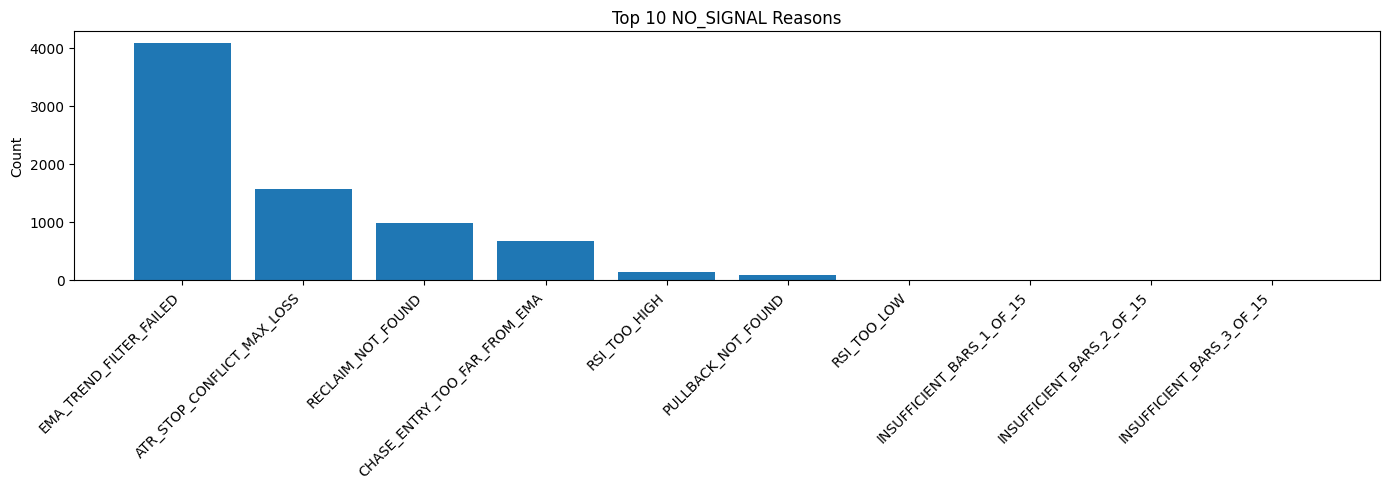

In [8]:
reason_items = sorted(report_json['no_signal_reason_counts'].items(), key=lambda x: x[1], reverse=True)[:10]

labels = [item[0] for item in reason_items]
values = [item[1] for item in reason_items]

plt.figure(figsize=(14, 5))
plt.bar(range(len(labels)), values)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.title('Top 10 NO_SIGNAL Reasons')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


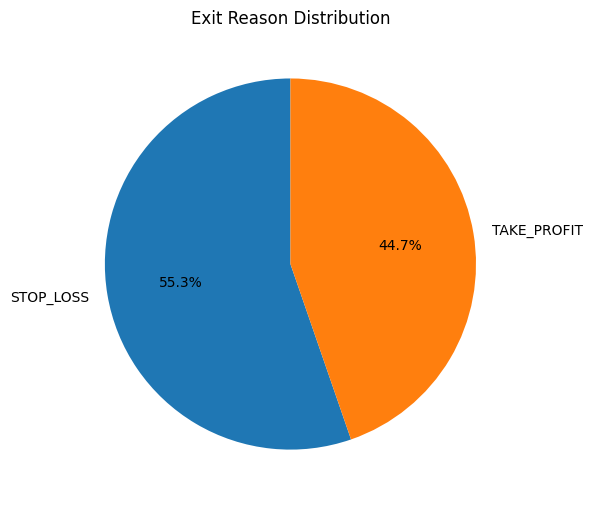

In [9]:
closed_trades = [t for t in report_json['trades'] if t.get('exit_reason') != 'OPEN']

if not closed_trades:
    print('No closed trades yet. Exit reason chart skipped.')
else:
    exit_counts = Counter(t.get('exit_reason', 'UNKNOWN') for t in closed_trades)
    labels = list(exit_counts.keys())
    values = [exit_counts[k] for k in labels]

    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Exit Reason Distribution')
    plt.tight_layout()
    plt.show()


{'pnl_metric_key': 'scaled_pnl_pct', 'initial_capital_jpy': 1000000, 'final_asset_jpy': 1217618.51, 'total_return_pct': 21.7619, 'max_drawdown_pct': -13.8033, 'max_drawdown_trade_index': 39}


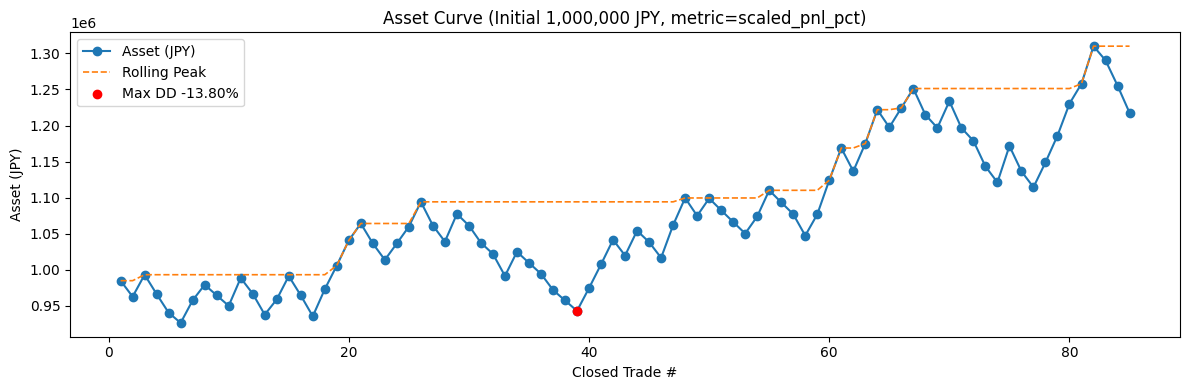

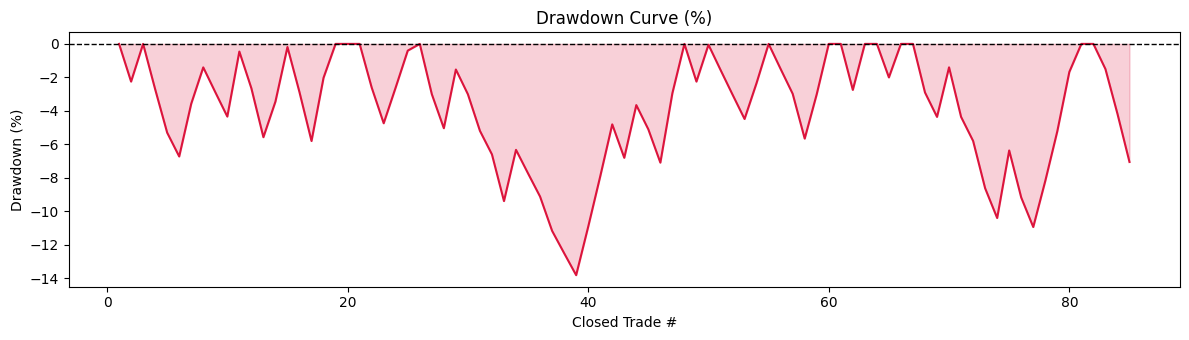

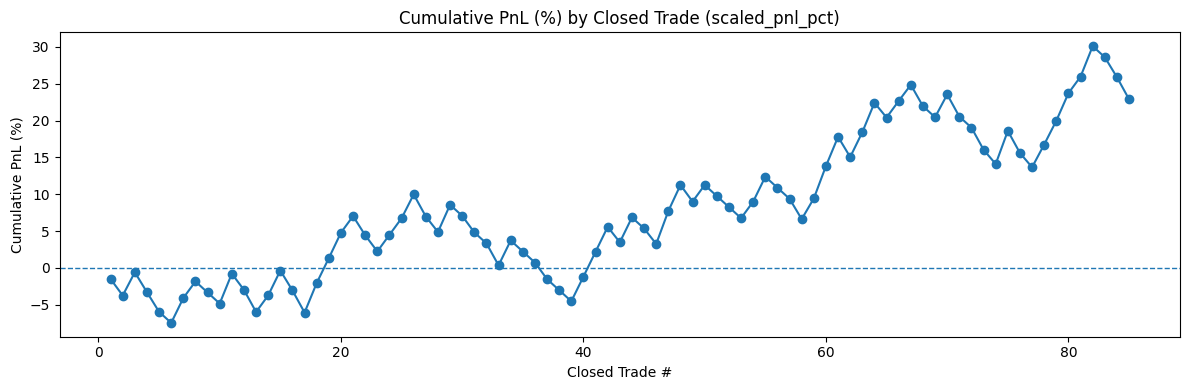

In [10]:
pnl_metric_key = 'scaled_pnl_pct' if any(t.get('scaled_pnl_pct') is not None for t in closed_trades) else 'pnl_pct'
pnl_pct_values = [t.get(pnl_metric_key) for t in closed_trades if t.get(pnl_metric_key) is not None]

if not pnl_pct_values:
    print('No closed trades yet. Equity / drawdown charts skipped.')
else:
    cumulative = []
    running = 0.0
    for value in pnl_pct_values:
        running += float(value)
        cumulative.append(running)

    equity_curve = []
    equity = float(INITIAL_CAPITAL_JPY)
    for value in pnl_pct_values:
        equity *= (1.0 + float(value) / 100.0)
        equity_curve.append(equity)

    peaks = []
    drawdowns = []
    peak = equity_curve[0]
    for value in equity_curve:
        peak = max(peak, value)
        peaks.append(peak)
        drawdowns.append((value / peak) - 1.0)

    max_drawdown = min(drawdowns)
    max_drawdown_pct = max_drawdown * 100.0
    max_dd_trade_index = drawdowns.index(max_drawdown) + 1

    final_asset = equity_curve[-1]
    total_return_pct = ((final_asset / float(INITIAL_CAPITAL_JPY)) - 1.0) * 100.0

    print({
        'pnl_metric_key': pnl_metric_key,
        'initial_capital_jpy': int(INITIAL_CAPITAL_JPY),
        'final_asset_jpy': round(final_asset, 2),
        'total_return_pct': round(total_return_pct, 4),
        'max_drawdown_pct': round(max_drawdown_pct, 4),
        'max_drawdown_trade_index': max_dd_trade_index,
    })

    x = list(range(1, len(equity_curve) + 1))

    plt.figure(figsize=(12, 4))
    plt.plot(x, equity_curve, marker='o', label='Asset (JPY)')
    plt.plot(x, peaks, linestyle='--', linewidth=1.2, label='Rolling Peak')
    plt.scatter([max_dd_trade_index], [equity_curve[max_dd_trade_index - 1]], color='red', zorder=5, label=f'Max DD {max_drawdown_pct:.2f}%')
    plt.title(f'Asset Curve (Initial {INITIAL_CAPITAL_JPY:,} JPY, metric={pnl_metric_key})')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Asset (JPY)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 3.5))
    drawdown_pct_series = [value * 100.0 for value in drawdowns]
    plt.plot(x, drawdown_pct_series, color='crimson')
    plt.fill_between(x, drawdown_pct_series, 0, color='crimson', alpha=0.2)
    plt.axhline(0, linestyle='--', linewidth=1, color='black')
    plt.title('Drawdown Curve (%)')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Drawdown (%)')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o')
    plt.axhline(0, linestyle='--', linewidth=1)
    plt.title(f'Cumulative PnL (%) by Closed Trade ({pnl_metric_key})')
    plt.xlabel('Closed Trade #')
    plt.ylabel('Cumulative PnL (%)')
    plt.tight_layout()
    plt.show()

from datetime import datetime

# Regime timing visualization (entry timing in UTC)
entry_trades = sorted(
    [trade for trade in report_json['trades'] if trade.get('entry_time')],
    key=lambda trade: trade['entry_time'],
)

if not entry_trades:
    print('No entry trades yet. Regime timing chart skipped.')
else:
    def _regime_from_multiplier(multiplier: float | None) -> str:
        if multiplier is None:
            return 'UNKNOWN'
        value = round(float(multiplier), 2)
        if value == 0.50:
            return 'STORM'
        if value == 0.75:
            return 'VOLATILE'
        if value == 1.00:
            return 'NORMAL'
        return f'CUSTOM_{value:.2f}'

    regime_colors = {
        'STORM': 'crimson',
        'VOLATILE': 'darkorange',
        'NORMAL': 'seagreen',
    }

    regime_to_times: dict[str, list[datetime]] = {}
    for trade in entry_trades:
        regime = _regime_from_multiplier(trade.get('position_size_multiplier'))
        entry_time = datetime.fromisoformat(trade['entry_time'].replace('Z', '+00:00'))
        regime_to_times.setdefault(regime, []).append(entry_time)

    ordered_regimes = [r for r in ['STORM', 'VOLATILE', 'NORMAL'] if r in regime_to_times]
    custom_regimes = sorted([r for r in regime_to_times if r not in {'STORM', 'VOLATILE', 'NORMAL'}])
    ordered_regimes.extend(custom_regimes)
    y_map = {regime: index for index, regime in enumerate(ordered_regimes)}

    plt.figure(figsize=(12, 4))
    for regime in ordered_regimes:
        times = regime_to_times.get(regime, [])
        if not times:
            continue
        y_values = [y_map[regime]] * len(times)
        color = regime_colors.get(regime, 'steelblue')
        plt.scatter(
            times,
            y_values,
            s=42,
            alpha=0.9,
            color=color,
            label=f"{regime} ({len(times)})",
        )

    plt.yticks([y_map[regime] for regime in ordered_regimes], ordered_regimes)
    plt.title('Entry Timing by Volatility Regime (UTC)')
    plt.xlabel('Entry Time (UTC)')
    plt.ylabel('Regime')
    plt.grid(axis='x', alpha=0.25)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1.0))
    plt.tight_layout()
    plt.show()


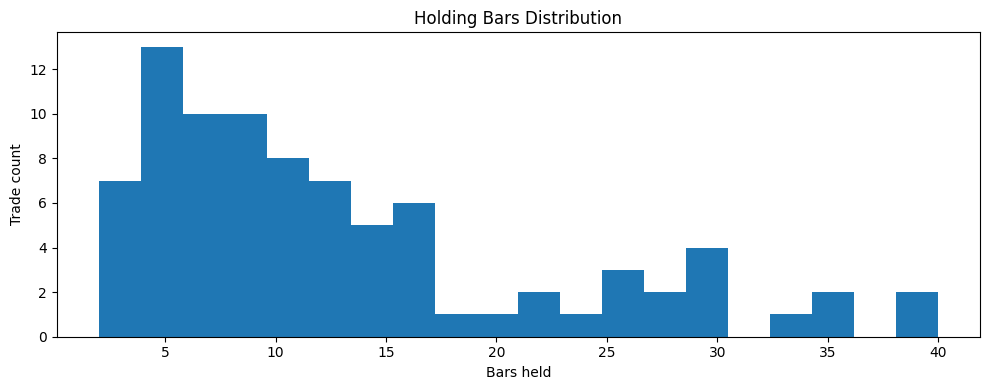

In [11]:
holding_bars = [t.get('holding_bars') for t in closed_trades if t.get('holding_bars') is not None]

if not holding_bars:
    print('No closed trades yet. Holding bars histogram skipped.')
else:
    unique_count = len(set(holding_bars))
    bins = min(max(unique_count, 5), 20)

    plt.figure(figsize=(10, 4))
    plt.hist(holding_bars, bins=bins)
    plt.title('Holding Bars Distribution')
    plt.xlabel('Bars held')
    plt.ylabel('Trade count')
    plt.tight_layout()
    plt.show()
